In [1]:
!pip install -q datasets
!pip install -q sentence_transformers
!pip install -q open_clip_torch
!pip install -q torch
!pip install -q clip_interrogator
!pip install transformers==4.26.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.3 MB/s eta 0:

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import open_clip
import torch
from sklearn import metrics
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import scipy
from clip_interrogator import Config, Interrogator
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset with the `2m_first_10k` subset
dataset = load_dataset('poloclub/diffusiondb', '2m_first_10k')
df = dataset['train'].to_pandas()
df.drop_duplicates(subset=['prompt'], inplace=True)
df['image'] = df['image'].apply(lambda x: x['path'])

df = df.sample(n=2000, random_state=42).reset_index(drop=True)

df.head(10)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,/root/.cache/huggingface/datasets/downloads/ex...,"classic oil painting, sci fi beautiful landsca...",3578732311,50,12.0,k_lms,1280,512,26da12cd3526e1b10319bb5d94ea516909c1cb4a5b77da...,2022-08-18 20:28:00+00:00,0.059204,0.000319
1,/root/.cache/huggingface/datasets/downloads/ex...,"3 panel scene, anime girl sleeps inside a cozy...",1787203390,50,5.0,k_lms,512,1024,56b9f823a65b1259d7a469d0e0726722e6f87297384c8f...,2022-08-20 02:43:00+00:00,0.183237,0.000596
2,/root/.cache/huggingface/datasets/downloads/ex...,"art by brian reedy, a beautiful black ink lino...",2790659476,50,10.0,k_lms,512,768,90702ef615cecfb7ad7611f88d3713e8c377ab4f19307e...,2022-08-18 20:20:00+00:00,0.131837,0.002152
3,/root/.cache/huggingface/datasets/downloads/ex...,a portrait painting of ulysses yen,2592126474,50,7.0,k_lms,512,512,08ac4153ab7e13baa55ee74213eb117a29a0024267b29e...,2022-08-18 16:57:00+00:00,0.081228,0.008096
4,/root/.cache/huggingface/datasets/downloads/ex...,an modern brazilian hotel lobby,1853182808,50,7.0,k_lms,512,512,db5f99224c964cb5b4c7df3e198120365e9fa31f1698d7...,2022-08-20 00:57:00+00:00,0.036470,0.000933
5,/root/.cache/huggingface/datasets/downloads/ex...,cute fluffy lion cheetah hybrid mixed creature...,367020193,50,7.0,k_lms,512,512,1fb38083263dfdf3fd5684d6407016e0357bebd5c3c45f...,2022-08-19 19:37:00+00:00,0.078598,0.001916
6,/root/.cache/huggingface/datasets/downloads/ex...,"a rat kitten, with rat face and cat body, phot...",2485589870,50,7.0,k_lms,512,512,1a417e499efa4c1d1de34a93223d9115663110f63c70c9...,2022-08-19 19:18:00+00:00,0.130636,0.054107
7,/root/.cache/huggingface/datasets/downloads/ex...,white chocolate glazed donut with strawberries...,2709335836,50,7.0,k_lms,512,512,30461e1aeaee651435637e0d043a488ba1e90c19ee87b0...,2022-08-18 14:34:00+00:00,0.037706,0.002602
8,/root/.cache/huggingface/datasets/downloads/ex...,potrait of cross between donald trump and joe ...,1949343048,50,10.4,k_lms,512,768,f76793016285403c9d3d85f12f3876b32f03d0e06a935a...,2022-08-18 22:06:00+00:00,0.059590,0.005964
9,/root/.cache/huggingface/datasets/downloads/ex...,photo illustration comics painting of small sc...,3987291150,50,7.0,k_lms,768,512,db6c3dd0cff968a4757de048ccbea6db8ac811e32db64c...,2022-08-19 21:31:00+00:00,0.043455,0.002285


In [4]:
df.shape

(2000, 12)

In [5]:
yolo_split = pd.read_csv('yolo_split_inter.csv')
yolo_split

,prompt,clip_inter_two_beam,clip_inter_fine_tune,yolo_count
0,la pieta ultrarealistic ultradetailed medium s...,a close up of person in mirror mummy portrait ...,a close up of person in mirror mummy portrait ...,3.0
1,a man in 1 9 3 0 s attire seen from behind wal...,a painting of man in tuxedo modern art noveau ...,a painting of man in tuxedo modern art noveau ...,3.0
2,a dark magus faces off against a vicious anubi...,a couple of men standing next to each other in...,a couple of people standing in front fire wayn...,2.0
3,"a unavowed, unconformist painting of people si...",a painting of group people sitting on couch ma...,a painting of group people sitting on couch ma...,4.0
4,beautiful white lioness three quarters profile...,a painting of white lion with feathers on its ...,a painting of lion with feathers on its head p...,3.0
...,...,...,...,...
140,close up of a heavily bloodied horrified prett...,a woman with long brown hair holding green bow...,a beautiful young woman holding green bowling ...,3.0
141,interior view overlooking a giant gargantuan w...,a large room with lot of yellow walls moving i...,a living room filled with lots of colorful fur...,6.0
142,a powerful human deity in their celestial doma...,a painting of woman with red cape boris vallej...,a painting of an angel on red background boris...,2.0
143,delicious hazelnut donut with chocolate glazin...,a couple of doughnuts sitting on top wooden cu...,a couple of doughnuts sitting on top wooden cu...,5.0


In [6]:
data = df.merge(yolo_split, on='prompt', how='inner')
data

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,clip_inter_two_beam,clip_inter_fine_tune,yolo_count
0,/root/.cache/huggingface/datasets/downloads/ex...,la pieta ultrarealistic ultradetailed medium s...,3414704076,50,2.9,k_lms,512,704,2b6c4abd103431d7dda4705e702187ce45fdd9af91c446...,2022-08-17 15:33:00+00:00,0.144012,0.002910,a close up of person in mirror mummy portrait ...,a close up of person in mirror mummy portrait ...,3.0
1,/root/.cache/huggingface/datasets/downloads/ex...,a man in 1 9 3 0 s attire seen from behind wal...,2228744458,50,7.0,k_lms,512,512,2766b4c9e3b8098986d651c8ce28c93c24373f24766a74...,2022-08-17 15:06:00+00:00,0.060114,0.006153,a painting of man in tuxedo modern art noveau ...,a painting of man in tuxedo modern art noveau ...,3.0
2,/root/.cache/huggingface/datasets/downloads/ex...,a dark magus faces off against a vicious anubi...,174591302,50,14.0,k_lms,896,704,d306e6436a608f5d683c58c945858193bd3de74f0793db...,2022-08-16 20:49:00+00:00,0.090585,0.003441,a couple of men standing next to each other in...,a couple of people standing in front fire wayn...,2.0
3,/root/.cache/huggingface/datasets/downloads/ex...,"a unavowed, unconformist painting of people si...",2154989697,50,7.0,k_lms,640,512,08ac4153ab7e13baa55ee74213eb117a29a0024267b29e...,2022-08-18 01:44:00+00:00,0.153906,0.015256,a painting of group people sitting on couch ma...,a painting of group people sitting on couch ma...,4.0
4,/root/.cache/huggingface/datasets/downloads/ex...,beautiful white lioness three quarters profile...,3818415420,50,7.0,k_lms,512,512,1fb38083263dfdf3fd5684d6407016e0357bebd5c3c45f...,2022-08-19 07:21:00+00:00,0.139428,0.005049,a painting of white lion with feathers on its ...,a painting of lion with feathers on its head p...,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,/root/.cache/huggingface/datasets/downloads/ex...,close up of a heavily bloodied horrified prett...,1084298391,50,7.0,k_lms,512,512,2766b4c9e3b8098986d651c8ce28c93c24373f24766a74...,2022-08-17 14:01:00+00:00,0.269470,0.071295,a woman with long brown hair holding green bow...,a beautiful young woman holding green bowling ...,3.0
141,/root/.cache/huggingface/datasets/downloads/ex...,interior view overlooking a giant gargantuan w...,3626869180,50,7.0,k_lms,768,512,9e1ee59715df5370f703859a2b08619783e31f55c05823...,2022-08-18 06:06:00+00:00,0.055339,0.026608,a large room with lot of yellow walls moving i...,a living room filled with lots of colorful fur...,6.0
142,/root/.cache/huggingface/datasets/downloads/ex...,a powerful human deity in their celestial doma...,1909740467,50,9.0,k_lms,512,704,1237e9ffa8656d947fddccc901989f84dfc366e824013a...,2022-08-17 03:17:00+00:00,0.235628,0.000540,a painting of woman with red cape boris vallej...,a painting of an angel on red background boris...,2.0
143,/root/.cache/huggingface/datasets/downloads/ex...,delicious hazelnut donut with chocolate glazin...,1956492651,50,7.0,k_lms,512,512,30461e1aeaee651435637e0d043a488ba1e90c19ee87b0...,2022-08-18 14:33:00+00:00,0.063682,0.002860,a couple of doughnuts sitting on top wooden cu...,a couple of doughnuts sitting on top wooden cu...,5.0


halle berry's face made of berries 


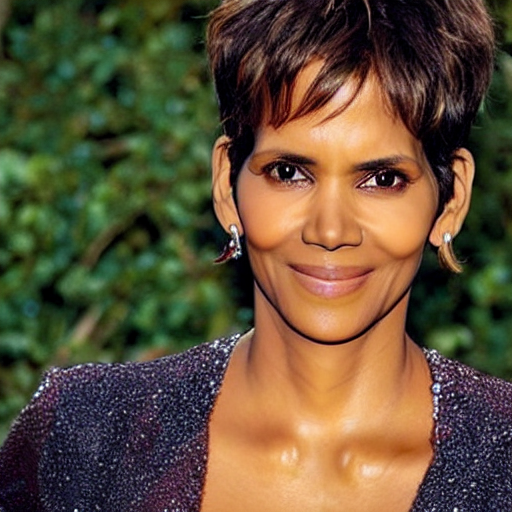

In [13]:
nums = np.random.randint(0, 1000, 1)

for i in nums :
    img = Image.open(df['image'][i])
    prompt = df['prompt'][i]
    print(prompt)
    display(img)

In [7]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install -q gradio
!pip install -q clip-interrogator
!pip install -q open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 7.7 MB/s eta 0:0

In [8]:
#@title Setup


clip_model_name = "ViT-H-14/laion2b_s32b_b79k" #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]


import gradio as gr
from clip_interrogator import Config, Interrogator

config = Config()
config.blip_num_beams = 24
config.blip_offload = False
config.clip_model_name = clip_model_name
ci = Interrogator(config)


def image_to_prompt(image, mode):
    ci.config.chunk_size = 1024 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 1024 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

Loading BLIP model...


  0%|          | 0.00/1.66G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...


ViT-H-14_laion2b_s32b_b79k_artists.safetensors: 100%|██████████| 21.6M/21.6M [00:00<00:00, 102MB/s]
ViT-H-14_laion2b_s32b_b79k_flavors.safetensors: 100%|██████████| 207M/207M [00:01<00:00, 104MB/s]
ViT-H-14_laion2b_s32b_b79k_mediums.safetensors: 100%|██████████| 195k/195k [00:00<00:00, 16.6MB/s]
ViT-H-14_laion2b_s32b_b79k_movements.safetensors: 100%|██████████| 410k/410k [00:00<00:00, 21.2MB/s]
ViT-H-14_laion2b_s32b_b79k_trendings.safetensors: 100%|██████████| 148k/148k [00:00<00:00, 12.1MB/s]
ViT-H-14_laion2b_s32b_b79k_negative.safetensors: 100%|██████████| 84.2k/84.2k [00:00<00:00, 14.3MB/s]

Loaded CLIP model and data in 342.63 seconds.


In [9]:
# put all phrases together in one string and droop duplicates
def drop_duplicates(phrase) :
    # remove duplicates but keep order
    unique_words = []
    for word in phrase.split() :
        if word not in unique_words :
            unique_words.append(word)
    return ' '.join(unique_words)

In [14]:
inter = image_to_prompt(img, "fast")
inter = ' '.join(inter.split(',')[:7])
inter = drop_duplicates(inter)
inter

100%|██████████| 110/110 [00:00<00:00, 323.44it/s]


'a close up of person with short hair halle berry stunning art intense smoldering high cheekbones inspiring prominent'

In [16]:
train = df.iloc[0:1500]
test = df.iloc[1500:2000]

train.shape, test.shape

((1500, 12), (500, 12))

In [18]:
train.head(1)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,/root/.cache/huggingface/datasets/downloads/ex...,"classic oil painting, sci fi beautiful landsca...",3578732311,50,12.0,k_lms,1280,512,26da12cd3526e1b10319bb5d94ea516909c1cb4a5b77da...,2022-08-18 20:28:00+00:00,0.059204,0.000319


In [19]:
test.head(1)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
1500,/root/.cache/huggingface/datasets/downloads/ex...,"lemonbrat studios bat fursuit, fursuiter, cand...",1758474385,50,10.0,k_lms,512,640,eaa41f839ff05c773bb8a0907424edbfeedf3ae4ccce84...,2022-08-16 19:17:00+00:00,0.114256,0.049717


In [11]:
count = 0

def get_inter_words(img) :
  image = Image.open(img)

  # split image into 4 quadrants
  width, height = image.size
  left = 0
  top = 0
  right = width / 2
  bottom = height / 2

  # crop image
  image1 = image.crop((left, top, right, bottom))
  image2 = image.crop((right, top, width, bottom))
  image3 = image.crop((left, bottom, right, height))
  image4 = image.crop((right, bottom, width, height))

  inter_0 = image_to_prompt(image, "fast")
  inter_0 = ' '.join(inter_0.split(',')[:7])
  inter_1 = image_to_prompt(image1, "fast")
  inter_1 = ' '.join(inter_1.split(',')[:7])
  inter_2 = image_to_prompt(image2, "fast")
  inter_2 = ' '.join(inter_2.split(',')[:7])
  inter_3 = image_to_prompt(image3, "fast")
  inter_3 = ' '.join(inter_3.split(',')[:7])
  inter_4 = image_to_prompt(image4, "fast")
  inter_4 = ' '.join(inter_4.split(',')[:7])

  all = inter_0 + ' ' + inter_1 + ' ' + inter_2 + ' ' + inter_3 + ' ' + inter_4
  all = drop_duplicates(all)
  
  global count
  count += 1
  if count % 25 == 0 :
    print(count)
  return all

data['clip_inter_yolo'] = data['image'].apply(get_inter_words)


100%|██████████| 110/110 [00:00<00:00, 354.77it/s]


25


100%|██████████| 110/110 [00:00<00:00, 359.89it/s]


50


100%|██████████| 110/110 [00:00<00:00, 356.14it/s]


75


100%|██████████| 110/110 [00:00<00:00, 368.77it/s]


100


100%|██████████| 110/110 [00:00<00:00, 339.45it/s]


125


100%|██████████| 110/110 [00:00<00:00, 361.54it/s]


In [12]:
data.head()

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,clip_inter_two_beam,clip_inter_fine_tune,yolo_count,clip_inter_yolo
0,/root/.cache/huggingface/datasets/downloads/ex...,la pieta ultrarealistic ultradetailed medium s...,3414704076,50,2.9,k_lms,512,704,2b6c4abd103431d7dda4705e702187ce45fdd9af91c446...,2022-08-17 15:33:00+00:00,0.144012,0.002910,a close up of person in mirror mummy portrait ...,a close up of person in mirror mummy portrait ...,3.0,a close up of person in mirror mummy portrait ...
1,/root/.cache/huggingface/datasets/downloads/ex...,a man in 1 9 3 0 s attire seen from behind wal...,2228744458,50,7.0,k_lms,512,512,2766b4c9e3b8098986d651c8ce28c93c24373f24766a74...,2022-08-17 15:06:00+00:00,0.060114,0.006153,a painting of man in tuxedo modern art noveau ...,a painting of man in tuxedo modern art noveau ...,3.0,a painting of man in tuxedo modern art noveau ...
2,/root/.cache/huggingface/datasets/downloads/ex...,a dark magus faces off against a vicious anubi...,174591302,50,14.0,k_lms,896,704,d306e6436a608f5d683c58c945858193bd3de74f0793db...,2022-08-16 20:49:00+00:00,0.090585,0.003441,a couple of men standing next to each other in...,a couple of people standing in front fire wayn...,2.0,a couple of people standing in front fire wayn...
3,/root/.cache/huggingface/datasets/downloads/ex...,"a unavowed, unconformist painting of people si...",2154989697,50,7.0,k_lms,640,512,08ac4153ab7e13baa55ee74213eb117a29a0024267b29e...,2022-08-18 01:44:00+00:00,0.153906,0.015256,a painting of group people sitting on couch ma...,a painting of group people sitting on couch ma...,4.0,a painting of group people sitting on couch ma...
4,/root/.cache/huggingface/datasets/downloads/ex...,beautiful white lioness three quarters profile...,3818415420,50,7.0,k_lms,512,512,1fb38083263dfdf3fd5684d6407016e0357bebd5c3c45f...,2022-08-19 07:21:00+00:00,0.139428,0.005049,a painting of white lion with feathers on its ...,a painting of lion with feathers on its head p...,3.0,a painting of lion with feathers on its head p...


In [13]:
export = data[['prompt', 'clip_inter_yolo']]
export.to_csv('clip_inter_yolo.csv', index=False)